In [702]:
%matplotlib inline

In [703]:
import matplotlib.pyplot as plt
import nengo
import numpy as np
import sspspace

In [704]:
samples = np.hstack([np.random.normal(loc=0, scale=0.5, size=7500),np.random.normal(loc=3, scale=0.5, size=2500)]) 

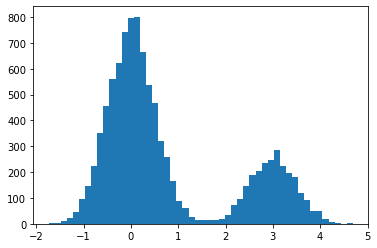

In [818]:
plt.hist(samples, bins=50);

In [884]:
D = 1024
ls = 0.2
rand_space = sspspace.RandomSSPSpace(ssp_dim=D, domain_dim=1)
rand_space.update_lengthscale(ls)

domain = np.linspace(-2, 4.5, 1000)
ddomain = domain[1] - domain[0]
samples_phi = rand_space.encode(samples[:,None])
domain_phi = rand_space.encode(domain[:,None])

In [889]:
N = 500
S = 5
encoders1 = rand_space.encode(np.linspace(-2, 4.5, N)[:,None])
encoders2 = rand_space.encode(np.random.uniform(-2, 4.5, N)[:,None])
encoders3 = rand_space.encode(np.random.uniform(-2, 4.5, size=(N*S,1))).reshape([N,S,-1]).sum(axis=1)
encoders4 = nengo.dists.UniformHypersphere(surface=True).sample(N, D)
encoders = encoders2

#ξ = -0.06
ξ = -0.08
#ξ = -0.13


In [905]:
model = nengo.Network()
with model:
    ens = nengo.Ensemble(n_neurons=N, dimensions=D,
                         encoders=encoders,
                         gain=np.ones(N),
                         bias=1+np.zeros(N)+ξ,
                         neuron_type=nengo.LIFRate(),
                         normalize_encoders=False,)
sim = nengo.Simulator(model)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

In [906]:
_, A_samples = nengo.utils.ensemble.tuning_curves(ens, sim, inputs=samples_phi)
_, A = nengo.utils.ensemble.tuning_curves(ens, sim, inputs=domain_phi)

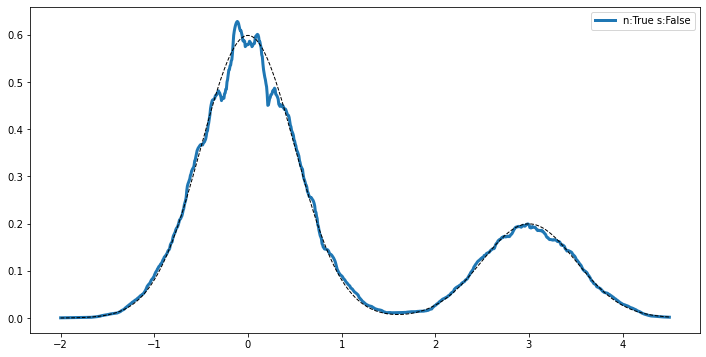

In [907]:
plt.figure(figsize=(12,6))

lw = 4

for normalize in [True]:
    for square in [False]:
        As = A_samples
        Aa = A
        
        if square:
            As = As**2
            #Aa = Aa**2

        ord = 2
        if normalize:
            As = As / np.linalg.norm(As, axis=1, ord=ord)[:,None]
            As = np.where(np.isnan(As), 0, As)

            Aa = Aa / np.linalg.norm(Aa, axis=1, ord=ord)[:,None]
            Aa = np.where(np.isnan(Aa), 0, Aa)

        dec = np.sum(As, axis=0)   # divide by length scale to be a kernel density estimator
        
        p = Aa @ dec
        
        p = p / np.sum(p) / ddomain
        
        plt.plot(domain, p, label=f'n:{normalize} s:{square}', lw=3)
        lw += 1
        
        
true = .75*np.exp(-((domain-0)**2)/(2*0.5**2)) + .25*np.exp(-((domain-3)**2)/(2*0.5**2)) 
true = true / np.sum(true) / ddomain
plt.plot(domain, true, lw=1, c='k', ls='--')

plt.legend()

In [862]:
def stim_func(t):
    index = int(t/0.001)-1
    index = index % (len(samples) + len(domain))
    if index < len(samples):
        return samples_phi[index]
    else:
        return domain_phi[index-len(samples)]

def normalize(t, x):
    norm = np.linalg.norm(x)
    if norm == 0:
        return norm
    else:
        return x / norm
    
model = nengo.Network()
with model:
    stim = nengo.Node(stim_func)
    
    ens = nengo.Ensemble(n_neurons=N, dimensions=D,
                         encoders=encoders,
                         gain=np.ones(N),
                         bias=np.zeros(N)+ξ,
                         neuron_type=nengo.RectifiedLinear(),
                         normalize_encoders=False,
                        )
    nengo.Connection(stim, ens, synapse=None)
    
    norm = nengo.Node(normalize, size_in=N, size_out=N)
    nengo.Connection(ens.neurons, norm, synapse=None)
    
    dec = np.zeros((1, N))
    
    def learning_rule(t, x):
        index = int(t/0.001)
        if index < len(samples):
            dec[:] += x
        return dec @ x
    
    learn = nengo.Node(learning_rule, size_in=N, size_out=1)
    
    nengo.Connection(norm, learn, synapse=None)
    
    p_out = nengo.Probe(learn)
    
sim = nengo.Simulator(model)
with sim:
    sim.run((len(samples) + len(domain)) *0.001)
    
        
    


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

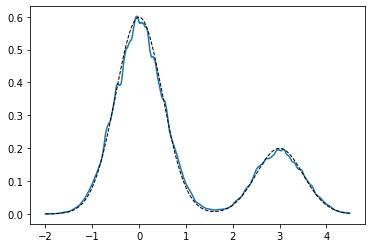

In [863]:
p = sim.data[p_out][-len(domain):]

p = p/np.sum(p)/ddomain

plt.plot(domain, p)


true = .75*np.exp(-((domain-0)**2)/(2*0.5**2)) + .25*np.exp(-((domain-3)**2)/(2*0.5**2)) 
true = true / np.sum(true) /ddomain
plt.plot(domain, true, lw=1, c='k', ls='--')
